<a href="https://colab.research.google.com/github/zhgjenny93/Capstones/blob/main/Capstone_2_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mental Health in Tech Survey Dataset

Mental health is an issue that is personal to me, and safe to say, everybody around me. Everyone either knows someone who suffers from a mental illness or has been/is afflicted by a mental illness themselves.

I found this set of data through [Open Sourcing Mental Illness](https://osmihelp.org/research), which is an organization trying to _'change how we talk about mental health in the tech community'_. Their mission is very relatable to current affairs as mental health awareness is gaining traction and becoming more talked about. Despite the growth in mental health awareness, through personal experiences, I believe there is still a lot of stigma surrounding the subject. I chose to study this particular topic in the hopes of understanding that stigma and identifying factors that may break that stigma.

I have decided to use both the 2014 and 2016 datasets as it will provide me with more data points and are the two largest datasets available through OSMI's surveys. Not all of the survey questions match, and there is a dramatic increase in variables in the 2016 dataset. In order to combine the two datasets, I will have to do a fair bit of data wrangling.

Let's get started by loading my libraries and datasets:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Prepping/Cleaning

In [ ]:
# read in data from 2014
raw_mh_2014_df = pd.read_csv('https://raw.githubusercontent.com/zhgjenny93/datasets/main/Mental%20Health%20in%20Tech%20Survey%202014.csv')
raw_mh_2014_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 27 columns):
 #   Column                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                                --------------  ----- 
 0   Timestamp                                                                                                             1260 non-null   object
 1   Age                                                                                                                   1260 non-null   int64 
 2   Gender                                                                                                                1260 non-null   object
 3   Country                                                                                                               1260 non-null   object
 4   If you live 

In order to combine the two datasets, I will have to rename the variables of both columns so the data can be matched when combined.

In [ ]:
# Shorten column names
new_cols = ['timestamp', 'age', 'sex', 'country', 'US_state', 'self_employed', 'mh_family_hist',
            'treatment_sought', 'mh_interferes_work', 'num_employees', 'remote_work',
            'employer_is_tech', 'employer_mh_benefits', 'employer_mh_benefit_options',
            'employer_discussed_mh', 'employer_mh_resources', 'anonymity_with_benefits',
            'mh_leave_is_easy', 'mh_discussion_negative_consequence', 
            'phys_discussion_negative_consequence', 'discuss_mh_coworkers',
            'discuss_mh_supervisor', 'mh_discuss_future_emp', 'phys_discuss_future_emp',
            'employer_sees_mh_eq_phys', 'observed_neg_conseq_from_coworkers', 'comments']


raw_mh_2014_df.columns = new_cols

Columns that are freeform, difficult to encode, and cannot really contribute to my classification models will be dropped.

In [ ]:
raw_mh_2014_df.drop(columns=['timestamp','comments'], inplace=True)

In [ ]:
raw_mh_2016_df = pd.read_csv('https://raw.githubusercontent.com/zhgjenny93/datasets/main/mental-heath-in-tech-2016_20161114.csv')
raw_mh_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

The 2016 dataset comes with a lot more questions that were asked and answered compared to the 2014 dataset. For the purpose of this exercise, I will only keep variables that overlap with the 2014 dataset.

In [ ]:
raw_mh_2016_df.drop(raw_mh_2016_df.columns[[3, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28,
                                            29, 30, 31, 32, 33, 34, 35,
                                            37, 39, 40, 41, 42, 43, 44,
                                            46, 47, 48, 49, 50, 51, 59,
                                            60, 61]], axis=1, inplace=True)

In [ ]:
raw_mh_2014_df.mh_interferes_work.value_counts()

Sometimes    466
Never        213
Rarely       173
Often        144
Name: mh_interferes_work, dtype: int64

In [ ]:
raw_mh_2016_df.iloc[:,19].value_counts()

Not applicable to me    557
Sometimes               369
Rarely                  322
Never                   120
Often                    65
Name: If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?, dtype: int64

In [ ]:
raw_mh_2016_df.iloc[:, 20].value_counts()

Often                   538
Not applicable to me    468
Sometimes               363
Rarely                   52
Never                    12
Name: If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?, dtype: int64

In [ ]:
# Based on value counts, I am more ready to drop column 20 than column 19, though this is just
# for this Capstone. In the real world, I will probably reconsider keeping the two datasets
# separate and/or doing more research.

raw_mh_2016_df.drop(raw_mh_2016_df.columns[[20]], axis=1, inplace=True)
# raw_mh_2016_df.info()

In [ ]:
# Renaming 2016 variables so they can match with 2014 variables

new_cols_16 = ['self_employed', 'num_employees', 'employer_is_tech', 'employer_mh_benefits',
               'employer_mh_benefit_options', 'employer_discussed_mh', 'employer_mh_resources',
               'anonymity_with_benefits', 'mh_leave_is_easy','mh_discussion_negative_consequence',
               'phys_discussion_negative_consequence', 'discuss_mh_coworkers', 'discuss_mh_supervisor',
               'employer_sees_mh_eq_phys', 'observed_neg_conseq_from_coworkers',
               'phys_discuss_future_emp', 'mh_discuss_future_emp', 'mh_family_hist',
               'treatment_sought', 'mh_interferes_work', 'age', 'sex', 'country',
               'US_state', 'remote_work']

raw_mh_2016_df.columns = new_cols_16

In [ ]:
# Combining the two datasets as one
raw_mh_df = pd.concat([raw_mh_2014_df, raw_mh_2016_df], ignore_index=True)

In [ ]:
print(raw_mh_df.country.value_counts())

# For this Capstone, let's only look at USA, as majority of the values are from USA.
raw_mh_df.country.replace(to_replace=['United States of America'], value='United States', inplace=True)
raw_mh_df.drop(raw_mh_df[raw_mh_df['country']!='United States'].index, inplace=True)

United States of America    840
United States               751
United Kingdom              365
Canada                      150
Germany                     103
                           ... 
Zimbabwe                      1
Thailand                      1
Algeria                       1
Brunei                        1
Vietnam                       1
Name: country, Length: 67, dtype: int64


In [ ]:
# Clean the 'age' column of unlikely values
raw_mh_df.drop(raw_mh_df[(raw_mh_df['age'] < 18) | (raw_mh_df['age'] > 90)].index, inplace=True)

In [ ]:
raw_mh_df.sex.unique()

array(['Female', 'M', 'Male', 'female', 'male', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'Cis Male', 'm', 'f',
       'Male (CIS)', 'queer/she/they', 'non-binary', 'Femake', 'woman',
       'Make', 'Nah', 'Genderqueer', 'Female ', 'Woman',
       'cis-female/femme', 'Male ', 'Trans woman', 'Man', 'msle',
       'Female (trans)', 'Female (cis)', 'Mail', 'cis male', 'femail',
       'female ', 'fm', 'Female or Multi-Gender Femme', 'female/woman',
       'Cis male', 'Male.', 'Male (cis)', 'Cisgender Female',
       'Sex is male', 'none of your business', 'genderqueer', 'Human',
       'Genderfluid', nan, 'genderqueer woman', 'mtf', 'Dude', 'mail',
       'Male/genderqueer', 'fem', 'human',
       'Female (props for making this a freeform field, though)',
       'Nonbinary', ' Female', 'Unicorn', 'Cis-woman', 'cisdude',
       'Genderflux demi-girl', 'cis man', 'AFAB', 'Agender', 'male ',
       'MALE'], dtype=object)

In [ ]:
# For the purpose of this Capstone, I will focus on a person's sex instead of gender, and will narrow
# the options down to male, female, and non-binary
raw_mh_df.sex.replace(to_replace=['Female', 'female', 'Cis Female', 'F', 'f', 'Femake',
                                  'woman', 'Female ', 'Woman', 'cis-female/femme',
                                  'Female (cis)', 'femail', 'female ', 'fm', 'female/woman',
                                  'Cisgender Female', 'fem', 
                                  'Female (props for making this a freeform field, though)',
                                  ' Female', 'Cis-woman', 'AFAB'], value='F', inplace=True)

raw_mh_df.sex.replace(to_replace=['M', 'Male', 'male', 'maile', 'Cis Male',
                                  'm', 'Male (CIS)', 'Make', 'Male ', 'Man', 'msle',
                                  'Mail', 'cis male', 'Cis male', 'Male.', 'Male (cis)',
                                  'Sex is male', 'Dude', 'mail', 'cisdude', 'cis man', 
                                  'male ', 'MALE'], value='M', inplace=True)

raw_mh_df.sex.replace(to_replace=['Male-ish', 'Trans-female', 'queer/she/they', 'non-binary',
                                  'Nah', 'Genderqueer', 'Trans woman', 'Female (trans)',
                                  'Female or Multi-Gender Femme', 'Other', 'none of your business',
                                  'genderqueer', 'Human', 'Genderfluid', 'genderqueer woman',
                                  'mtf', 'Male/genderqueer', 'human', 'Nonbinary', 'Unicorn',
                                  'Genderflux demi-girl', 'Agender', np.nan], value='Non-binary',
                      inplace=True)

In [ ]:
# I found this dictionary online so I can convert all US state values to their abbreviations

# United States of America Python Dictionary to translate States,
# Districts & Territories to Two-Letter codes and vice versa.
#
# https://gist.github.com/rogerallen/1583593
#
# Dedicated to the public domain.  To the extent possible under law,
# Roger Allen has waived all copyright and related or neighboring
# rights to this code.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))


raw_mh_df['US_state'] = raw_mh_df.US_state.map(us_state_abbrev).fillna(raw_mh_df['US_state'])

In [ ]:
raw_mh_df.isna().sum()

age                                       0
sex                                       0
country                                   0
US_state                                 11
self_employed                            11
mh_family_hist                            0
treatment_sought                          0
mh_interferes_work                      142
num_employees                           131
remote_work                               0
employer_is_tech                        131
employer_mh_benefits                    131
employer_mh_benefit_options             157
employer_discussed_mh                   131
employer_mh_resources                   131
anonymity_with_benefits                 131
mh_leave_is_easy                        131
mh_discussion_negative_consequence      131
phys_discussion_negative_consequence    131
discuss_mh_coworkers                    131
discuss_mh_supervisor                   131
mh_discuss_future_emp                     0
phys_discuss_future_emp         

In [ ]:
# Assume that this question with no answer implies that the question does not apply to the survey taker.
# This is based on my own judgement, and I think it is a safe judgement on this particular variable

raw_mh_df.mh_interferes_work.replace(to_replace=np.nan, value='Not applicable to me', inplace=True)

In [ ]:
# Drop rows with more than 13 NaN values, as I am uncertain what to replace these NaN values with

raw_mh_df.dropna(thresh=13, inplace=True)

raw_mh_df.dropna(subset=['US_state'], inplace=True)

# Drop the country column since it is only the US
raw_mh_df.drop(raw_mh_df.columns[[2]], axis=1, inplace=True)

In [ ]:
raw_mh_df.isna().sum()

age                                      0
sex                                      0
US_state                                 0
self_employed                           11
mh_family_hist                           0
treatment_sought                         0
mh_interferes_work                       0
num_employees                            0
remote_work                              0
employer_is_tech                         0
employer_mh_benefits                     0
employer_mh_benefit_options             26
employer_discussed_mh                    0
employer_mh_resources                    0
anonymity_with_benefits                  0
mh_leave_is_easy                         0
mh_discussion_negative_consequence       0
phys_discussion_negative_consequence     0
discuss_mh_coworkers                     0
discuss_mh_supervisor                    0
mh_discuss_future_emp                    0
phys_discuss_future_emp                  0
employer_sees_mh_eq_phys                 0
observed_ne

In [ ]:
raw_mh_df.replace(to_replace=["I don't know", "Don't know", 'Not sure', 'I am not sure', 
                              'Maybe', 'Some of them', 'Sometimes', 'Non-binary'],
                  value=2, inplace=True)
raw_mh_df.replace(to_replace=['Yes', 'Always', 'Often', 'F'], 
                  value=1, inplace=True)

# I think it is safe again to assume that the remaining NaN values indicate a 'No' or 'N/A' answer
raw_mh_df.replace(to_replace=['No', 'Not eligible for coverage / N/A', 'Never', 
                              'Not applicable to me', 'Rarely', np.nan, 'M'], 
                  value=0, inplace=True)


In [ ]:
# Replace mh_leave_is_easy with encoded values
raw_mh_df.mh_leave_is_easy.replace(to_replace=['Very easy', 'Somewhat easy',
                        'Neither easy nor difficult', 'Somewhat difficult',
                        'Very difficult'], value=[0, 1, 2, 3, 4], inplace=True)

In [ ]:
raw_mh_df.employer_is_tech = raw_mh_df.employer_is_tech.apply(np.int64)

for index, val in enumerate(list(raw_mh_df.columns)):
  ans = raw_mh_df[val].unique()
  print(index, val)
  print(ans)
  print('\n')

0 age
[37 44 31 33 35 42 36 29 32 46 41 34 40 27 50 30 38 22 24 26 23 25 28 45
 18 39 43 21 60 54 55 57 58 48 47 62 65 56 19 49 20 51 53 72 52 61 66 59
 63 74 70]


1 sex
[1 0 2]


2 US_state
['IL' 'IN' 'TX' 'TN' 'MI' 'OH' 'CA' 'CT' 'MD' 'NY' 'NC' 'MA' 'IA' 'PA'
 'WA' 'WI' 'UT' 'NM' 'OR' 'FL' 'MN' 'MO' 'AZ' 'CO' 'GA' 'DC' 'NE' 'WV'
 'OK' 'KS' 'VA' 'NH' 'KY' 'AL' 'NV' 'NJ' 'SC' 'VT' 'SD' 'ID' 'MS' 'RI'
 'WY' 'LA' 'ME' 'ND' 'MT' 'AK' 'DE']


3 self_employed
[0 1]


4 mh_family_hist
[0 1 2]


5 treatment_sought
[1 0]


6 mh_interferes_work
[1 0 2]


7 num_employees
['6-25' 'More than 1000' '100-500' '1-5' '26-100' '500-1000']


8 remote_work
[0 1 2]


9 employer_is_tech
[1 0]


10 employer_mh_benefits
[1 2 0]


11 employer_mh_benefit_options
[2 0 1]


12 employer_discussed_mh
[0 2 1]


13 employer_mh_resources
[1 2 0]


14 anonymity_with_benefits
[1 2 0]


15 mh_leave_is_easy
[1 2 3 4 0]


16 mh_discussion_negative_consequence
[0 2 1]


17 phys_discussion_negative_consequence
[0 2 1]


18

## Data visualization
I will now look at the data after I've performed some cleaning in order to understand what it is that I am working with. For this particular exercise, my outcome of interest is whether or not a person will seek treatment for mental health problems, so I will start with looking at the distribution of that variable. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


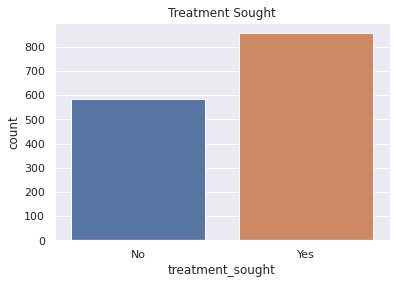

In [ ]:
# Various distributions
sns.countplot(raw_mh_df.treatment_sought)
plt.title('Treatment Sought')
plt.xticks([0,1], labels=['No', 'Yes'])
plt.show()

I am plotting out other variables of interest, and have combined a couple of variables that can be comparable. Notably, these variables are whether a person will discuss their mental health issue with a coworker or supervisor, and whether or not a person will discuss a physical or mental health issue with a potential employer.

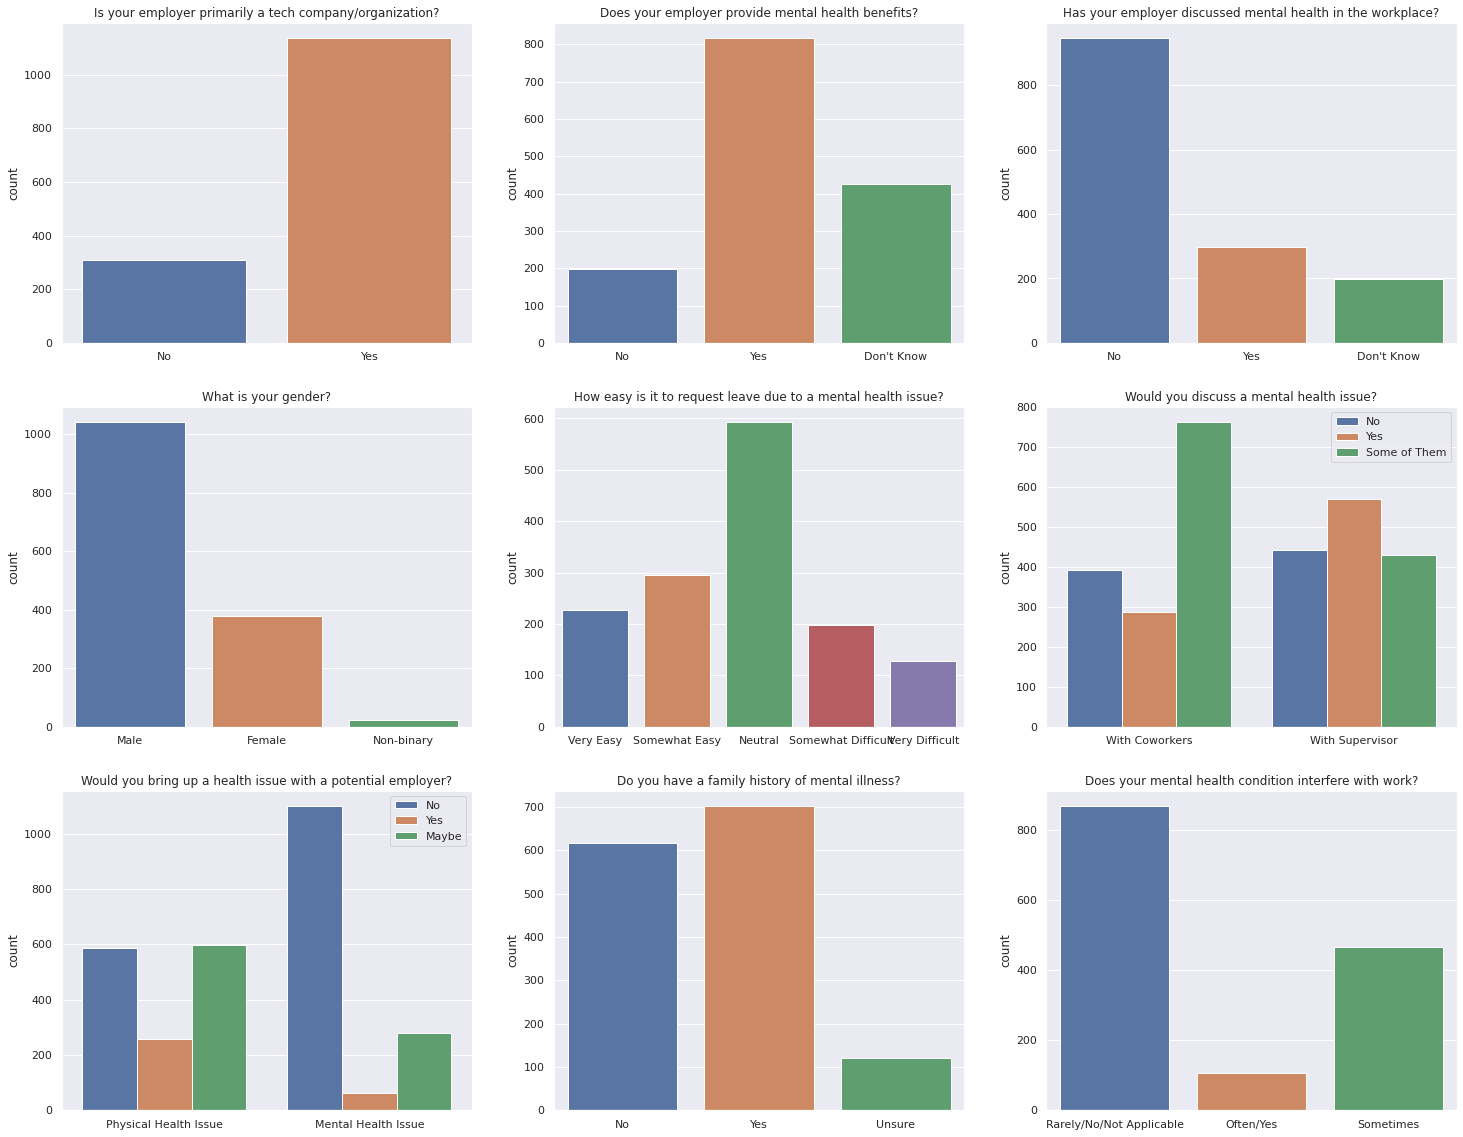

In [ ]:
plt.figure(figsize=(25,20))

plt.subplot(3,3,1)
sns.countplot(data=raw_mh_df, x='employer_is_tech')
plt.title('Is your employer primarily a tech company/organization?')
plt.xticks([0,1], labels=['No', 'Yes'])
plt.xlabel('')

plt.subplot(3,3,2)
sns.countplot(data=raw_mh_df, x='employer_mh_benefits')
plt.title('Does your employer provide mental health benefits?')
plt.xticks([0,1,2], ['No', 'Yes', "Don't Know"])
plt.xlabel('')

plt.subplot(3,3,3)
sns.countplot(data=raw_mh_df, x='employer_discussed_mh')
plt.title('Has your employer discussed mental health in the workplace?')
plt.xticks([0,1,2], ['No', 'Yes', "Don't Know"])
plt.xlabel('')

plt.subplot(3,3,4)
sns.countplot(data=raw_mh_df, x='sex')
plt.title('What is your gender?')
plt.xticks([0,1,2], ['Male', 'Female', 'Non-binary'])
plt.xlabel('')

plt.subplot(3,3,5)
sns.countplot(data=raw_mh_df, x='mh_leave_is_easy')
plt.title('How easy is it to request leave due to a mental health issue?')
plt.xticks([0,1,2,3,4], ['Very Easy', 'Somewhat Easy', 'Neutral', 'Somewhat Difficult', 'Very Difficult'])
plt.xlabel('')

plt.subplot(3,3,6)
discuss=raw_mh_df[['discuss_mh_coworkers', 'discuss_mh_supervisor']]
sns.countplot(x='variable', hue='value', data=pd.melt(discuss))
plt.title('Would you discuss a mental health issue?')
plt.xticks([0,1], ['With Coworkers', 'With Supervisor'])
plt.legend(('No', 'Yes', 'Some of Them'))
plt.xlabel('')

plt.subplot(3,3,7)
health=raw_mh_df[['phys_discuss_future_emp', 'mh_discuss_future_emp']]
sns.countplot(x='variable', hue='value', data=pd.melt(health))
plt.title('Would you bring up a health issue with a potential employer?')
plt.xticks([0,1],['Physical Health Issue', 'Mental Health Issue'])
plt.legend(('No', 'Yes', 'Maybe'))
plt.xlabel('')

plt.subplot(3,3,8)
sns.countplot(data=raw_mh_df, x='mh_family_hist')
plt.title('Do you have a family history of mental illness?')
plt.xticks([0,1,2], ['No', 'Yes', 'Unsure'])
plt.xlabel('')

plt.subplot(3,3,9)
sns.countplot(data=raw_mh_df, x='mh_interferes_work')
plt.title('Does your mental health condition interfere with work?')
plt.xticks([0,1,2], ['Rarely/No/Not Applicable', 'Often/Yes', 'Sometimes'])
plt.xlabel('')

plt.show()


These plots alone can provide some interesting insights on mental health in the tech industry, and the general tech industry itself.

As expected, most of the survey takers work in the tech industry; we can also see that most of the survery takers identify as male. This is either an indicator that the survey was presented and taken by mostly men, or perhaps a more likely scenario - that the tech industry is predominantly male. This is an observation that came about as a bonus commentary on the tech industry in this study. I decided to explore how sex/gender correlates to mental health treatment a little later.

I can also see that, overwhelmingly, the workplaces of the survey takers do not discuss mental health as a part of the company's wellness program. However, most companies do provide medical benefits that encompass mental health treatments. Again, this can lead to a social discussion of whether it is a good thing that mental health is not discussed - and treated the same as other physcial ailments that remain undiscussed and broadly accepted, or whether a conversation should be had with employees as mental health is an emerging health issue still tied with heavy stigma. That being said, the dataset does not provide whether physical health is addressed as part of the company's wellness programs, or if the company has a wellness program at all.

It also appears that most employees will not bring up their mental health issue to a potential employer, and will not let their mental health issue interfere with work (under the assumption that they are being treated for their mental health affliction). The first part does not surprise me as any illness is personal and not required to be disclosed to employers by law. The latter part seems to provide a hopeful outlook for those who are suffering from mental illnesses that treatment can help with work performance and hopefully general day-to-day life - this variable is also further evaluated later on.

### Data Visualization: Probability of seeking treatment in groups of interest

One of my first thoughts when I cleaned the data on the question '*what is your gender?*' was that due to historical oppression and rejection by society, people who identify other than 'male' or 'female' probably suffer more often from mental health illnesses. Along with previous knowledge that women tend to seek mental health more often than men, I was intrigued to see how that played out with this dataset.

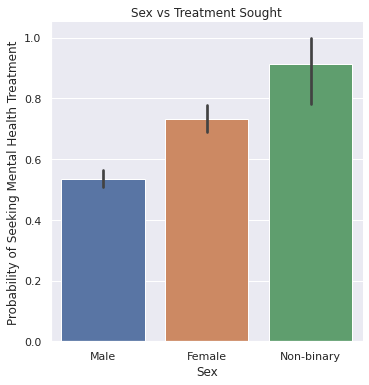

In [ ]:
sns.catplot(data=raw_mh_df, x='sex', y='treatment_sought', kind='bar')

plt.title('Sex vs Treatment Sought')
plt.xlabel('Sex')
plt.ylabel('Probability of Seeking Mental Health Treatment')
plt.xticks([0,1,2], ['Male', 'Female', 'Non-binary'])
plt.show()

It is clear that despite most survey takers identify as men, based on probability, people with non-binary gender identities and women are more likely to seek mental health treatment. Information like this is valuable in identifying men as a group that may need more outreach or resources regarding mental health acceptance and treatment.

I decided to dive a little further and see if availability of mental health benefits affected people's decisions in seeking treatment. The plot below shows that people with non-binary gender identities sought help regardless of availability of benefits. Both men and women were more likely to seek treatment when their employers' medical plans covered mental health treatments, but the disparity between seeking treatment with or without benefits is much smaller amongst men.

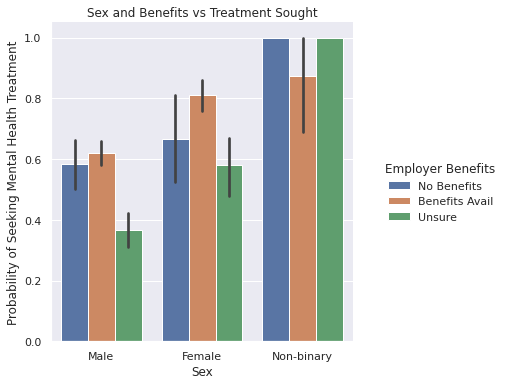

In [ ]:
g = sns.catplot(data=raw_mh_df, x='sex', y='treatment_sought', hue='employer_mh_benefits', kind='bar', legend_out=True)

plt.title('Sex and Benefits vs Treatment Sought')
plt.xlabel('Sex')
plt.ylabel('Probability of Seeking Mental Health Treatment')
plt.xticks([0,1,2], ['Male', 'Female', 'Non-binary'])

# Replace Legend labels
new_title='Employer Benefits'
g._legend.set_title(new_title)
new_labels = ['No Benefits', 'Benefits Avail', 'Unsure']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.show()

Another observation of interest to me was whether mental health having an impact on someone's work prompted them to seek mental heatlh treatment. Whilest the plot above showed only whether or not an employee's mental health interfered with their work, it did not identify whether that person had a mental health issue in the first place. The plot below shows that overwhelmingly, those who sought mental health treatment had mental health issues that interfered with their work.

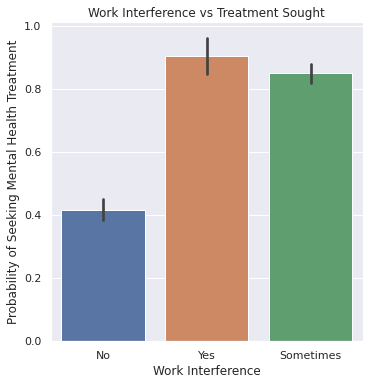

In [ ]:
g = sns.catplot(data=raw_mh_df, x='mh_interferes_work', y='treatment_sought', kind='bar', legend_out=True)

plt.title('Work Interference vs Treatment Sought')
plt.xlabel('Work Interference')
plt.ylabel('Probability of Seeking Mental Health Treatment')
plt.xticks([0,1,2], ['No', 'Yes', 'Sometimes'])

# Replace Legend labels
# new_title='Employer Benefits'
# g._legend.set_title(new_title)
# new_labels = ['No Benefits', 'Benefits Avail', 'Unsure']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.show()

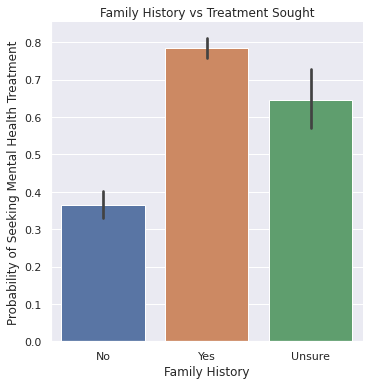

In [ ]:
g = sns.catplot(data=raw_mh_df, x='mh_family_hist', y='treatment_sought', kind='bar', legend_out=True)

plt.title('Family History vs Treatment Sought')
plt.xlabel('Family History')
plt.ylabel('Probability of Seeking Mental Health Treatment')
plt.xticks([0,1,2], ['No', 'Yes', 'Unsure'])

# Replace Legend labels
# new_title='Employer Benefits'
# g._legend.set_title(new_title)
# new_labels = ['No Benefits', 'Benefits Avail', 'Unsure']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

plt.show()

I wanted to see if age played a factor in seeking mental health treatment as well. Interestingly, age did not seem to be a huge identifier in seeking or not seeking mental heatlh treatment.

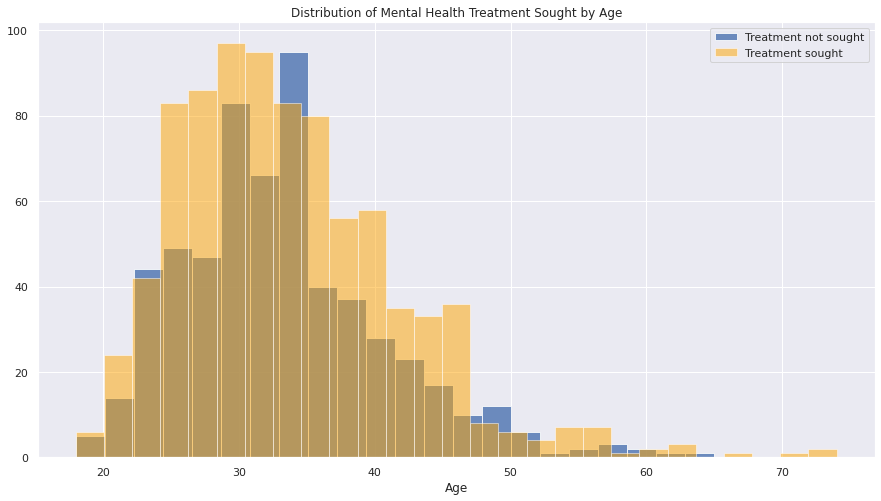

In [ ]:
p1 = raw_mh_df.loc[raw_mh_df.treatment_sought==0, 'age']
p2 = raw_mh_df.loc[raw_mh_df.treatment_sought==1, 'age']

plt.figure(figsize=(15,8))
plt.hist(p1, alpha=0.8, color='b', bins='auto', label='Treatment not sought')
plt.hist(p2, alpha=0.5, color='orange', bins='auto', label='Treatment sought')
plt.gca().set(title='Distribution of Mental Health Treatment Sought by Age', xlabel='Age')
plt.legend()

## Correlation Matrices

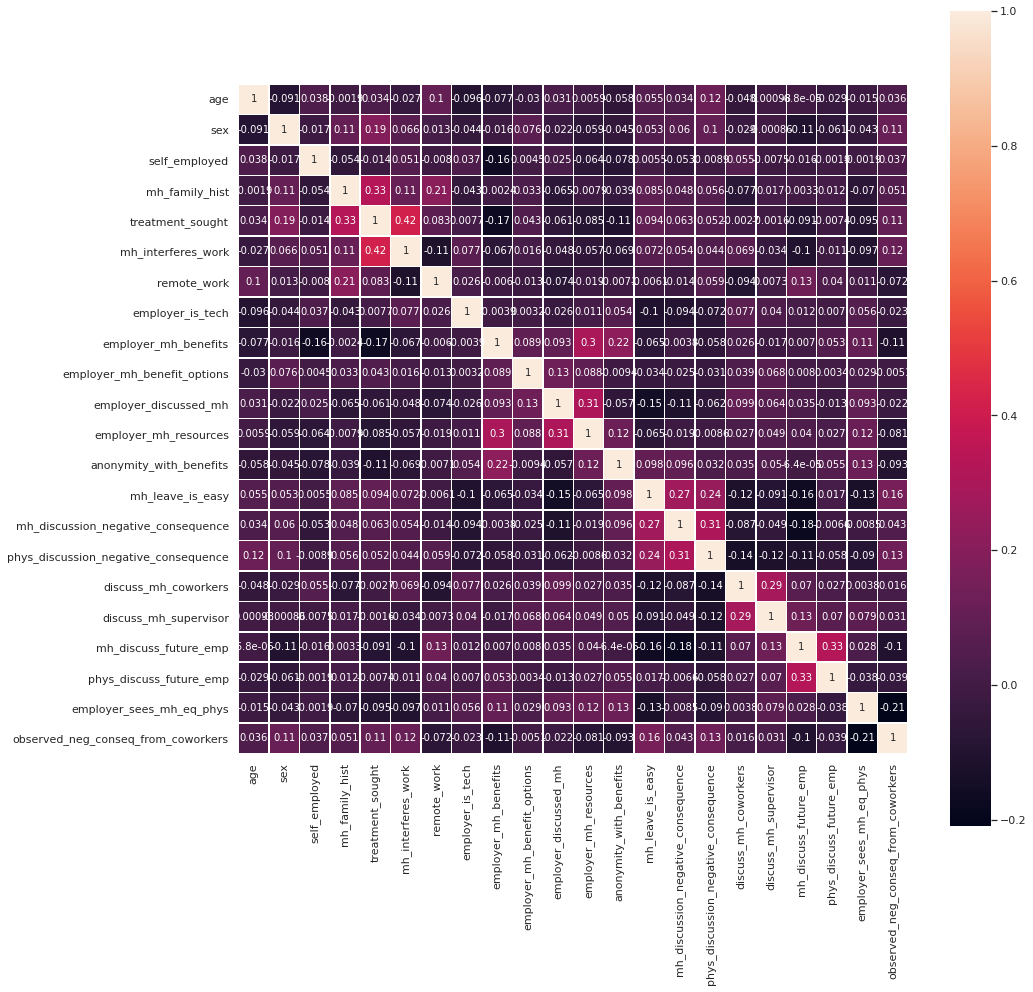

In [ ]:
corrmat = raw_mh_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corrmat, square=True, linewidths=0.5, annot=True)
plt.show()

### Correlation Plot with respect to Treatment Sought

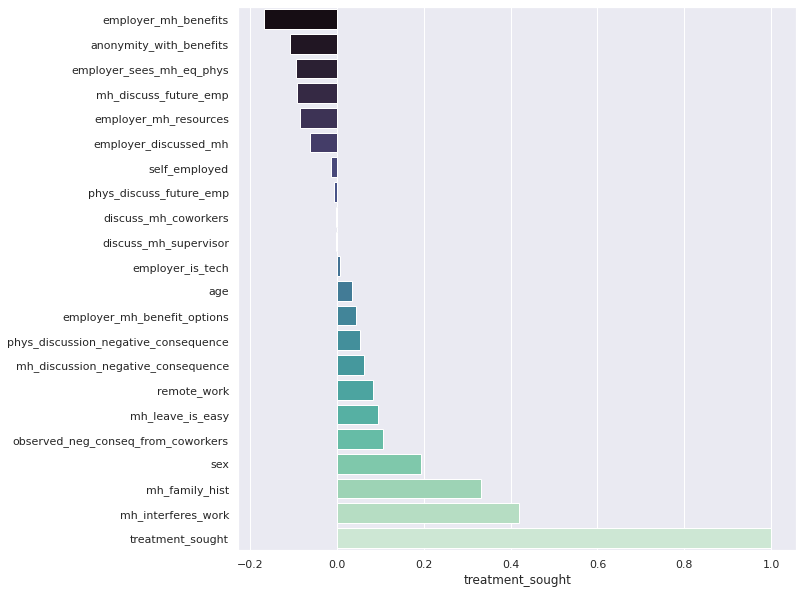

In [ ]:
corr_treatment = raw_mh_df.corr()['treatment_sought'].sort_values()

plt.figure(figsize=(10,10))
sns.barplot(x=corr_treatment, y=corr_treatment.index, palette='mako')

In [ ]:
# One-hot encode states and number of employees
raw_mh_df=pd.concat([raw_mh_df, pd.get_dummies(raw_mh_df.US_state, drop_first=True)], axis=1)
raw_mh_df=pd.concat([raw_mh_df, pd.get_dummies(raw_mh_df.num_employees, prefix='num_employees', drop_first=True)], axis=1)

## Preparing Data for Modeling

In [ ]:
target = raw_mh_df.treatment_sought

# Split test and train set and performing some feature selection based on correlation matrix
X = raw_mh_df.drop(labels=['treatment_sought', 'US_state', 'num_employees', 'discuss_mh_coworkers', 'discuss_mh_supervisor', 'phys_discuss_future_emp','self_employed','employer_is_tech'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8, random_state=123)

In [ ]:
# importing an external funtion to plot confusion matrix results for later use

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Logistic Regression Model and Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

lr=LogisticRegression(max_iter=10000) # put max_iter to converge herehere instead of tuning
parameters = {'solver':['newton-cg', 'lbfgs', 'sag'], 'C':np.arange(0.05,0.5,0.05)} # tune C:
lr_clf = GridSearchCV(lr, parameters, cv=10)
lr_clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'solver': ['newton-cg', 'lbfgs', 'sag']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Retrain a new model based on the best parameters
lr_params = lr_clf.best_params_
print(lr_params)
lr = LogisticRegression(**lr_params)
lr.fit(X_train, y_train)

{'C': 0.05, 'solver': 'newton-cg'}


LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

Training model best score: 0.77


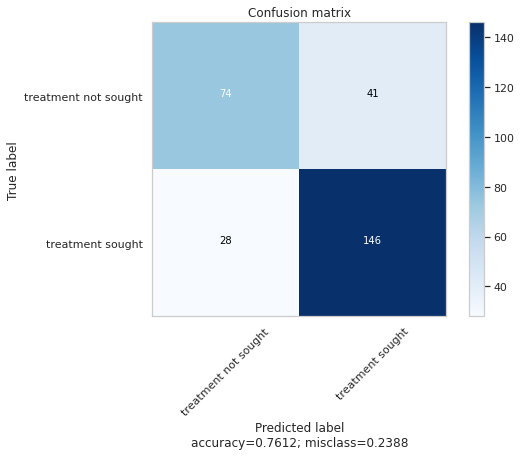

                      precision    recall  f1-score   support

Treatment Not Sought       0.73      0.64      0.68       115
    Treatment Sought       0.78      0.84      0.81       174

            accuracy                           0.76       289
           macro avg       0.75      0.74      0.75       289
        weighted avg       0.76      0.76      0.76       289



In [ ]:
print('Training model best score: {:.2f}'.format(lr_clf.best_score_))

# Make predictions based on the model with best performing parameters
predictions = lr.predict(X_test)
confusion = confusion_matrix(y_test, predictions, labels=[0,1])

sns.set_style('whitegrid', {'axes.grid':False})
plot_confusion_matrix(cm=confusion, target_names=['treatment not sought', 'treatment sought'], normalize=False)

report = classification_report(y_test, predictions, target_names=['Treatment Not Sought', 'Treatment Sought'])
print(report)

In [ ]:
# Evaluate performance of the model across the entire set of data
print(cross_val_score(lr, X, target, cv=10))
print(np.mean(cross_val_score(lr, X, target, cv=10)))

[0.77931034 0.80689655 0.8125     0.77083333 0.78472222 0.73611111
 0.67361111 0.77777778 0.74305556 0.75      ]
0.7634818007662835


## Random Forest Model

In [ ]:
rfc = RandomForestClassifier()
parameters={'n_estimators':[30,40,50,60,70,80,90,100], 'max_depth':[5,6,7,8,9,10,11,12], 'min_samples_split':[2], 'criterion':['gini', 'entropy']}
rfc_clf = GridSearchCV(rfc, parameters)
rfc_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
# Retrain a new model based on the best parameters

rfc_params = rfc_clf.best_params_

rfc = RandomForestClassifier(**rfc_params)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Training model best score: 0.80


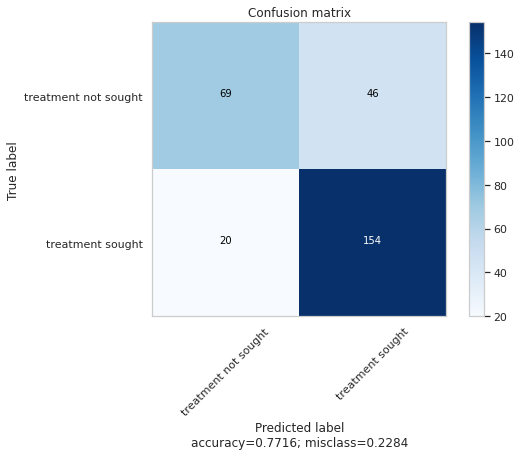

                      precision    recall  f1-score   support

Treatment Not Sought       0.78      0.60      0.68       115
    Treatment Sought       0.77      0.89      0.82       174

            accuracy                           0.77       289
           macro avg       0.77      0.74      0.75       289
        weighted avg       0.77      0.77      0.77       289



In [ ]:
print('Training model best score: {:.2f}'.format(rfc_clf.best_score_))

# Make predictions based on the model with best performing parameters
predictions = rfc.predict(X_test)
confusion = confusion_matrix(y_test, predictions, labels=[0,1])

plot_confusion_matrix(cm=confusion, target_names=['treatment not sought', 'treatment sought'], normalize=False)

report = classification_report(y_test, predictions, target_names=['Treatment Not Sought', 'Treatment Sought'])
print(report)

In [ ]:
print(cross_val_score(rfc, X, target, cv=10))
print(np.mean(cross_val_score(rfc, X, target, cv=10)))

[0.76551724 0.82758621 0.79166667 0.77777778 0.81944444 0.80555556
 0.70833333 0.76388889 0.77777778 0.75694444]
0.7850095785440613


## Support Vector Machine

In [ ]:
svm = SVC()
parameters={'kernel':['linear', 'poly', 'rbf'], 'C':np.arange(0.25,5.00,0.25)}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Retrain a new model based on the best parameters

params = clf.best_params_

svm = SVC(**params)
svm.fit(X_train, y_train)

SVC(C=4.75, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Training model best score: 0.77


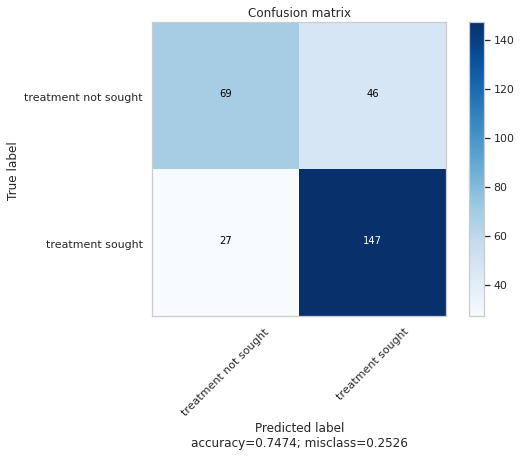

                      precision    recall  f1-score   support

Treatment Not Sought       0.72      0.60      0.65       115
    Treatment Sought       0.76      0.84      0.80       174

            accuracy                           0.75       289
           macro avg       0.74      0.72      0.73       289
        weighted avg       0.74      0.75      0.74       289



In [ ]:
print('Training model best score: {:.2f}'.format(clf.best_score_))

# Make predictions based on the model with best performing parameters
predictions = svm.predict(X_test)
confusion = confusion_matrix(y_test, predictions, labels=[0,1])

plot_confusion_matrix(cm=confusion, target_names=['treatment not sought', 'treatment sought'], normalize=False)

report = classification_report(y_test, predictions, target_names=['Treatment Not Sought', 'Treatment Sought'])
print(report)

In [ ]:
print(cross_val_score(svm, X, target, cv=10))
print(np.mean(cross_val_score(svm, X, target, cv=10)))

[0.79310345 0.8        0.79166667 0.75694444 0.79166667 0.73611111
 0.72222222 0.78472222 0.75694444 0.73611111]
0.7669492337164752


## Conclusion

Based on the three models and tuning through GridSearchCV, the Random Forest model was consistently the most accurate at 80% even with changing parameters. It beats out the linear regression and support vector machine models by 3% to 6% through various iterations. I believe that with more practice and more skills on tuning, data cleaning, and feature engineering, this model can still be improved upon. 

There are a few shortcomings for this model. I made a few assumption on converting NaN values to 0 (or 'no') values; I only looked at US data and dropped data from other countries; half of the variables from 2016 dataset were dropped in order to combine with the 2014 model; and I made an assumption on a particular variable regarding mental health issues interfering work performance with/without treatment. 

My personal assumptions may have introduced incorrect data, and a lot of data was lost from the columns dropped in the 2016 dataset, and the dropped countries. Perhaps if the models were conducted on the 2014 dataset, and 2016 dataset separately, the accuracy could be higher, on the same token, perhaps it may not have performed as well as the combined set.

Another factor to note, there may be some external factors that can introduce some volatility to people's mental health conditions - for example, 2016 being an election year. I don't see how in this particular case, the mental health of the general population in 2014 can be drastically different to 2016, it is something that is interesting to think about, considering the 2020 pandemic has wrecked havoc on people's mental health across the globe.

Overall, this study has provided some insight into the mental health of people working in the tech industry. I hope that the discussion on mental health continues to grow as stigma surrounding this very real issue continues to shrink.

Use XGboost,

talk about the features that you decided to end up using/feature importance

include f1, recall, and precision scores

ROC curve